In [164]:
import re, orodja
import pandas as pd
import matplotlib.pyplot as plt
file = 'osu_index.txt'
aux_file = 'data-auxf.txt'
page = 'https://osu.ppy.sh/beatmapsets?sort=difficulty_desc&s=ranked'

## Auxilary code to make a file if one doesn't already exist

In [165]:
def create_files(files=[file, aux_file, 'data.json', 'data.csv']):
    for f in files:
        try:
            a = open(f, 'x')
            a.close()
        except:
            continue

Regex here

In [166]:
curr_re = r'\{"beatmapsets":\[(.*?)\]\}\]'
data_block_re = r'\{.*?\}\]\}'
data_re = re.compile(
    r'\{'
    r'"artist":(?P<artist>.*?)?,.*?,'
    r'"creator":(?P<creator>.*)?,' 
    r'"favourite_count":(?P<fav_count>\d*)?,.*?,'
    r'"id":(?P<id>\d*)?,.*?,'
    r'"play_count":(?P<play_count>\d*)?,.*?,'
    r'"status":(?P<status>.*)?,'
    r'"title":(?P<title>.*?)?,.*?,'
    r'"bpm":(?P<bpm>\d*)?,.*?'
    r'"tags":"(?P<tags>.*?)?",'
    r'"beatmaps":\[(?P<beatmapset>.*?)?\]'
    r'\}',
    flags=re.DOTALL
)

beatmapset_re = re.compile(
    r'\{.*?\}',
    flags=re.DOTALL
)

bmaux_re = re.compile(
    r'[^\\]',
    flags=re.DOTALL
)

beatmap_re = re.compile(
    r'\{.*?,'
    r'"difficulty_rating":(?P<difficulty_rating>.*?),'
    r'"id":(?P<id>\d*?),.*?,'
    r'"total_length":(?P<map_len>\d*?),.*?,'
    r'"accuracy":(?P<accuracy>.*?),'
    r'"ar":(?P<approach_rate>.*?),'
    r'"bpm":(?P<beatmap_bpm>\d*?),.*?,'
    r'"passcount":(?P<passcount>\d*?),'
    r'"playcount":(?P<playcount>\d*?),.*?,'
    r'"max_combo":(?P<max_combo>\d*?)\}',
    flags=re.DOTALL
)

## Separate code snippets here

In [167]:
def scrape(fin: str, out: str) -> None:
    regex = re.compile(curr_re, flags=re.DOTALL) #re.DOTALL postav piko na vse, vkljucno s novo vrstico
    with open(fin) as f:
        stuff = f.read()
        with open(out, 'w', encoding='UTF8')as o:
            print(re.findall(regex, stuff), file=o)

In [168]:
def make_blocks(filename: str) -> list:
    l = []
    with open(filename) as f:
        stuff = f.read()
    regex = re.compile(data_block_re, flags=re.DOTALL)
    for block in re.findall(regex, stuff):
        l.append(block)
    return l

In [169]:
def scrape_block(block: str) -> dict:
    if not block: return {}
    map = data_re.search(block).groupdict()
    map['fav_count'] = int(map.get('fav_count', 0))
    map['id'] = int(map.get('id', 0))
    map['play_count'] = int(map.get('play_count', 0))
    map['bpm'] = int(map['bpm']) 
    map['tags'] = map['tags'].split(' ')
    # map['beatmapset'] = scrape_beatmaps(map.get('beatmapset', ''))
    beatmapsset_string =  map.get('beatmapset', '')
    l = []
    for match in re.findall(r'\{.*?\}', beatmapsset_string):
        l.append(beatmap_re.search(match).groupdict())
    map['beatmapset'] = l
    return map

In [170]:
def error_check(block: str) -> bool: #eni so prazni iz nekga razloga
    try:
        scrape_block(block)
        return True
    except:
        print('Empty match!')
        return False

Replaces (if \_\_name__ == '\_\_main__')

In [171]:
create_files()
orodja.shrani_spletno_stran(page, file, vsili_prenos=True)
scrape(file, aux_file)
data_blocks = make_blocks(aux_file)
data = []
for i, block in enumerate(data_blocks):
    if not error_check(block):
        print(i)
        continue
    data.append(scrape_block(block))
orodja.zapisi_json(data, 'data.json')
data_format = [
    'id', 
    'title', 
    'creator',
    'artist', 
    'fav_count', 
    'play_count', 
    'bpm', 
    'status', 
    'tags', 
    'beatmapset'
    ]
orodja.zapisi_csv(data, data_format, 'data.csv')

Empty match!
4
Empty match!
20
Empty match!
25
Empty match!
39


From here is more code for data points and analysis

In [172]:
def filter_tags(l:list[str]) -> list[str]: #tole je nazalost treba ker unfiltered list item je ubistvu samo en doug string
    tags_re = re.compile(
        r'\w+',
        re.DOTALL
    )
    s = re.findall(tags_re, l)
    for i, chars in enumerate(s):
        if chars == '':
            s.pop(i)
    return s

we're gonna need a little bit of extra code to sort through the raw unicode characters

In [173]:
def unicode_checker(s:str) -> bool:
    uni_re = re.compile(r'u[\d\w]{4}', flags=re.DOTALL)
    if re.match(uni_re, s): return True
    return False

In [174]:
def sort_tags(s: pd.Series, reverse=True) -> list[tuple]:
    tags_filtered = s.apply(filter_tags)
    u = {}
    for tags in tags_filtered:
        for tag in tags: #ta dvojn for loop je zelo fajn
            if unicode_checker(tag): continue
            if u == {} or tag not in u.keys():
                u[tag] = 1
            else:
                u[tag] += 1
    return sorted(u.items(), key=lambda x:x[1], reverse=reverse)

Another (if \_\_name__ == '__main\_\_') part

<AxesSubplot: xlabel='Tag'>

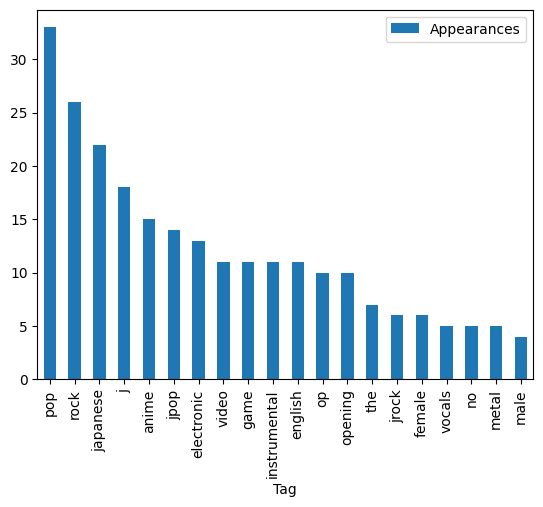

In [175]:
df = pd.read_csv('data.csv')
subtable = df[['id', 'title', 'tags']]
all_tags_sorted = sort_tags(df.tags)
all_tags_sorted_table = pd.DataFrame(all_tags_sorted, columns=['Tag' , 'Appearances'])
all_tags_sorted_table.head(20).plot.bar(x='Tag', y='Appearances')

This next one is of ***FIGURATIVE*** nature, caution is advised

Run this snippet only if you want to _spawn satan himself onto this world_, otherwise it's unnecessary

In [176]:
%%script false --no-raise-error
figure1, ax1 = plt.subplots()
ax1.pie(all_tags_sorted_table.Appearances, labels=all_tags_sorted_table.Tag, autopct='%1.1f%%', shadow=False, startangle=0)
ax1.axis('equal')
plt.title('The Antichrist')
#i'm submitting  this one just because of how cursed it is head(20)
plt.show()

### Random stuff

In [177]:
sum([all_tags_sorted_table.head(20).Appearances])

0     33
1     26
2     22
3     18
4     15
5     14
6     13
7     11
8     11
9     11
10    11
11    10
12    10
13     7
14     6
15     6
16     5
17     5
18     5
19     4
Name: Appearances, dtype: int64

In [178]:
sort_tags(df.tags)


[('pop', 33),
 ('rock', 26),
 ('japanese', 22),
 ('j', 18),
 ('anime', 15),
 ('jpop', 14),
 ('electronic', 13),
 ('video', 11),
 ('game', 11),
 ('instrumental', 11),
 ('english', 11),
 ('op', 10),
 ('opening', 10),
 ('the', 7),
 ('jrock', 6),
 ('female', 6),
 ('vocals', 5),
 ('no', 5),
 ('metal', 5),
 ('male', 4),
 ('bass', 4),
 ('2', 4),
 ('vocal', 4),
 ('ost', 4),
 ('vocalist', 4),
 ('music', 4),
 ('alternative', 4),
 ('hardcore', 4),
 ('world', 3),
 ('a', 3),
 ('4', 3),
 ('atlas', 3),
 ('2022', 3),
 ('full', 3),
 ('n', 3),
 ('idol', 3),
 ('soundtrack', 3),
 ('chan', 3),
 ('metalcore', 3),
 ('meme', 3),
 ('k', 3),
 ('ji', 3),
 ('artcore', 2),
 ('glassy', 2),
 ('character', 2),
 ('denyi', 2),
 ('iv', 2),
 ('1', 2),
 ('aeniko', 2),
 ('and', 2),
 ('featured', 2),
 ('artist', 2),
 ('fa', 2),
 ('tachibana_', 2),
 ('egts', 2),
 ('sound', 2),
 ('osu', 2),
 ('4k', 2),
 ('finals', 2),
 ('dnb', 2),
 ('drum', 2),
 ('drumstep', 2),
 ('to', 2),
 ('sunshine', 2),
 ('tv', 2),
 ('kazuno', 2),
 ('tan

In [179]:
l = df.tags[0] #jesus christ okay this thing returns one giant string
s = df.tags.apply(filter_tags)
s[23]

['anohana',
 'ano',
 'hi',
 'mita',
 'hana',
 'no',
 'namae',
 'wo',
 'bokutachi',
 'wa',
 'mada',
 'shiranai',
 'hokichi',
 'the',
 'flower',
 'we',
 'saw',
 'that',
 'day',
 'opening',
 'op',
 'blue',
 'bookmark',
 'u30ac',
 'u30ea',
 'u30ec',
 'u30aa',
 'u30ac',
 'u30ea',
 'u30ec',
 'u30a4',
 'anime',
 'japanese',
 'pop',
 'jpop',
 'j',
 'pop',
 'male',
 'vocals',
 'vocal',
 'vocalist',
 'revialink',
 'tachibana_']